## 📦 Data Preprocessing
Load and preview the dataset.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('dark_background')

# Load dataset
df_test = pd.read_csv('data/test_new.csv', usecols=['brand', 'market', 'review_title', 'review_text', 'review_rating'])
df_train = pd.read_csv('data/train_new.csv', usecols=['brand', 'market', 'review_title', 'review_text', 'review_rating'])
#df_test = df_test.sample(n=10000)  # Limiting to first 250 for demo
#df_train = df_train.sample(n=10000)

# Quick look
print(df_test.shape)
df_test.head()


(14063, 5)


,brand,market,review_title,review_text,review_rating
0,Downy,US,Downy Softness,I used to stay away from scented laundry produ...,5.0
1,Tide,US,NaN,Great Item,5.0
2,Cascade,US,Five Stars,"Arrived soon, product is as expected.",5.0
3,Swiffer,US,Five Stars,"yup, these work well!",5.0
4,Swiffer,US,Too Costly Considering the Result.,If you have a relatively clean floor with a fe...,2.0


## 📊 Exploratory Data Analysis
Visualizing review rating distribution.

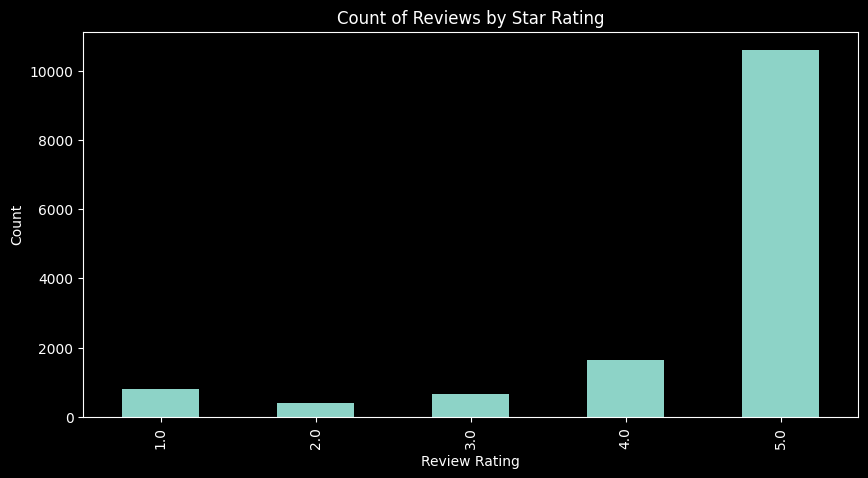

In [72]:
ax = df_test['review_rating'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Star Rating',
    figsize=(10,5)
)
ax.set_xlabel('Review Rating')
ax.set_ylabel('Count')
plt.show()


## 🧹 Text Cleaning
Lowercasing, removing punctuation, numbers, extra spaces.

In [73]:
def clean_text(text_series):
    text_series = text_series.str.replace(r'[^\w\s]', '', regex=True)
    text_series = text_series.str.lower()
    text_series = text_series.str.strip()
    text_series = text_series.str.replace(r'\s+', ' ', regex=True)
    text_series = text_series.str.replace(r'\d+', '', regex=True)
    return text_series.astype(str)

df_test['cleaned_text'] = clean_text(df_test['review_text'])
df_train['cleaned_text'] = clean_text(df_train['review_text'])

df_test['label'] = df_test['review_rating'].astype(int)
df_train['label'] = df_train['review_rating'].astype(int)

## 🧠 Tokenization and POS Tagging
Basic NLP steps using NLTK.

In [74]:
example = df_test['cleaned_text'].iloc[0]
tokens = nltk.word_tokenize(example)
tagged = nltk.pos_tag(tokens)

print("Tokens:", tokens[:10])
print("Tagged:", tagged[:10])


Tokens: ['i', 'used', 'to', 'stay', 'away', 'from', 'scented', 'laundry', 'products', 'due']
Tagged: [('i', 'NN'), ('used', 'VBN'), ('to', 'TO'), ('stay', 'VB'), ('away', 'RB'), ('from', 'IN'), ('scented', 'VBN'), ('laundry', 'NN'), ('products', 'NNS'), ('due', 'JJ')]


## 2. TF-IDF + Naive Bayes and Logistic Regression

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf.fit_transform(df_train['cleaned_text'])
X_test = tfidf.transform(df_test['cleaned_text'])
y_train = df_train['label']
y_test = df_test['label']

nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)

lr = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


## 3. Evaluation Metrics & Confusion Matrix

Naive Bayes Performance:
              precision    recall  f1-score   support

           1      0.716     0.183     0.291       788
           2      0.000     0.000     0.000       399
           3      0.444     0.012     0.024       645
           4      0.315     0.025     0.047      1631
           5      0.769     0.995     0.868     10600

    accuracy                          0.764     14063
   macro avg      0.449     0.243     0.246     14063
weighted avg      0.677     0.764     0.677     14063

Logistic Regression Performance:
              precision    recall  f1-score   support

           1      0.369     0.571     0.448       788
           2      0.101     0.243     0.143       399
           3      0.197     0.394     0.263       645
           4      0.234     0.390     0.293      1631
           5      0.915     0.680     0.780     10600

    accuracy                          0.615     14063
   macro avg      0.363     0.456     0.385     14063
weighted avg      0

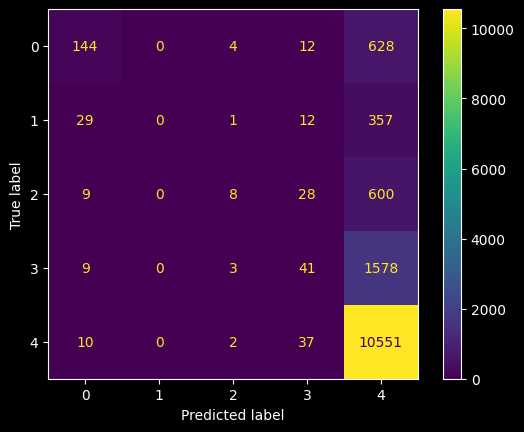

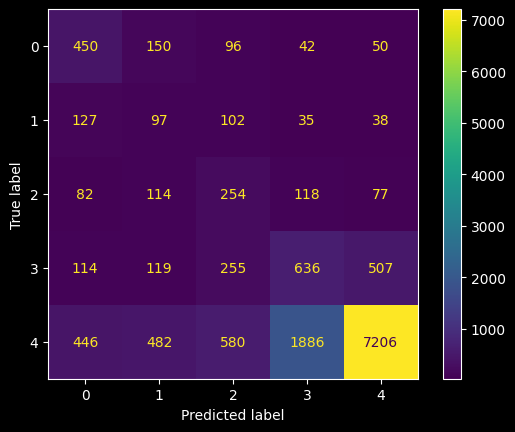

In [76]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Naive Bayes Performance:")
print(classification_report(y_test, nb_preds, digits=3, zero_division=0))
ConfusionMatrixDisplay(confusion_matrix(y_test, nb_preds)).plot()

print("Logistic Regression Performance:")
print(classification_report(y_test, lr_preds, digits=3, zero_division=0))
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds)).plot()


## 4. Multi-Class ROC Curves

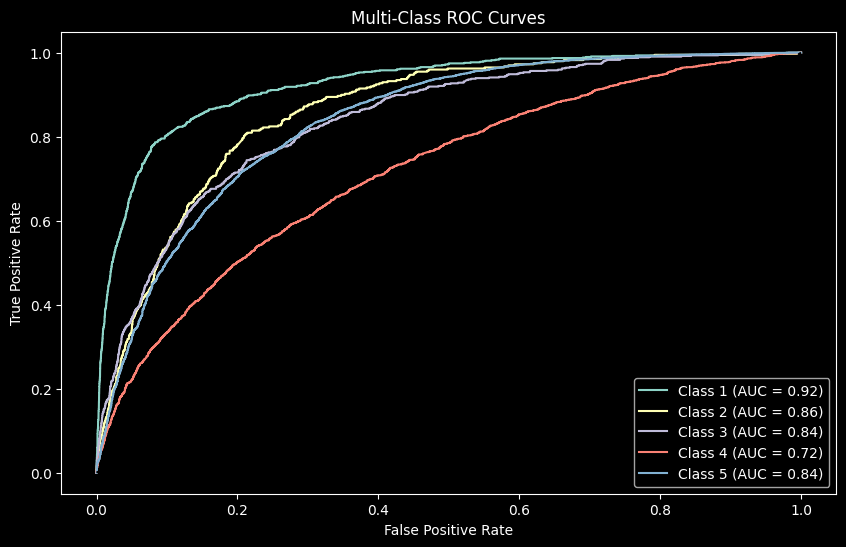

In [77]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

classes = sorted(df_train['label'].unique())
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
ovr.fit(X_train, y_train_bin)
y_score = ovr.predict_proba(X_test)

import matplotlib.pyplot as plt
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multi-Class ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## 5. Word Clouds by Sentiment

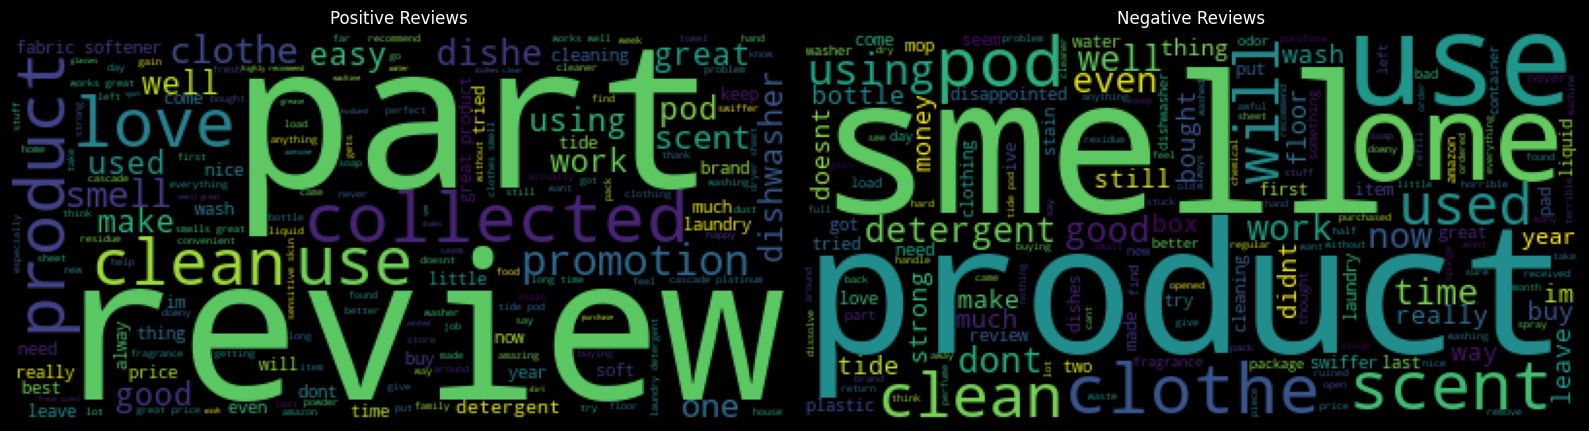

In [78]:

from wordcloud import WordCloud

pos_reviews = df_train[df_train['label'] >= 4]['cleaned_text'].str.cat(sep=' ')
neg_reviews = df_train[df_train['label'] <= 2]['cleaned_text'].str.cat(sep=' ')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.imshow(WordCloud(background_color='black').generate(pos_reviews))
ax1.set_title("Positive Reviews")
ax1.axis('off')

ax2.imshow(WordCloud(background_color='black').generate(neg_reviews))
ax2.set_title("Negative Reviews")
ax2.axis('off')

plt.tight_layout()
plt.show()


## 6. Trend Analysis by Brand or Market

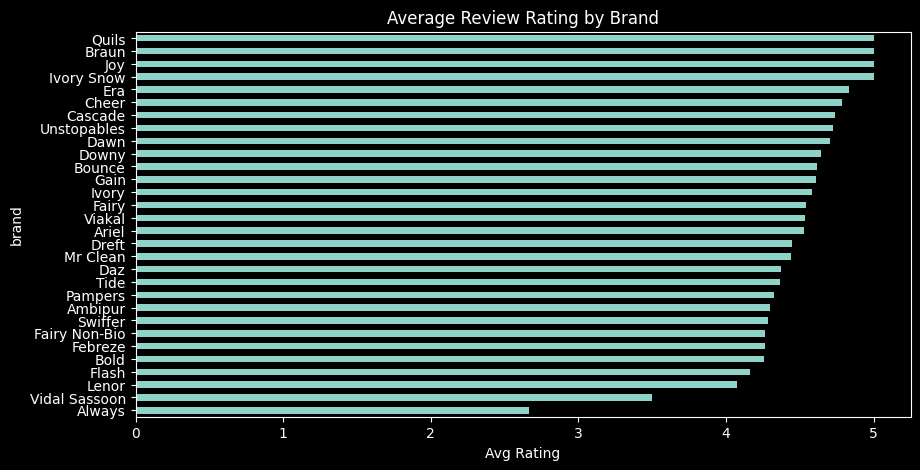

In [79]:
df_train.groupby('brand')['review_rating'].mean().sort_values().plot(kind='barh', figsize=(10,5))
plt.title("Average Review Rating by Brand")
plt.xlabel("Avg Rating")
plt.show()


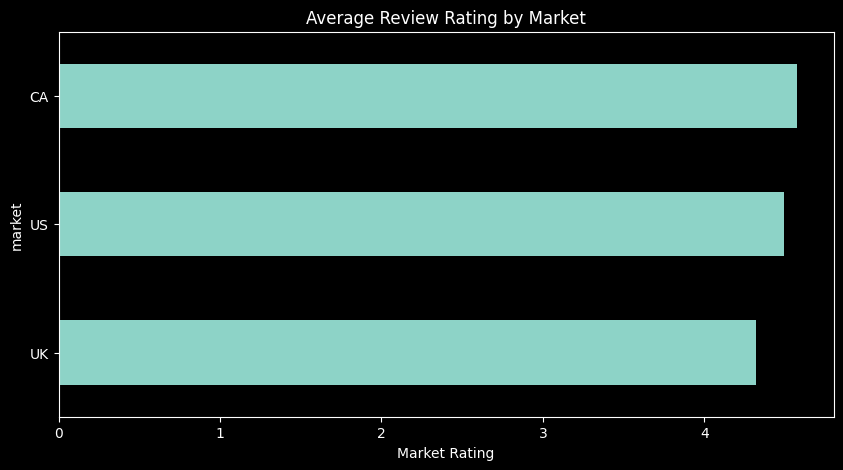

In [80]:
df_train.groupby('market')['review_rating'].mean().sort_values().plot(kind='barh', figsize=(10,5))
plt.title("Average Review Rating by Market")
plt.xlabel("Market Rating")
plt.show()